In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
import os

## Get Data

In [2]:
# define data transfomrations for data augmentation and normalization
data_transforms = {
    # data augmentation
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(), # resnet needs input as tensors
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.255]) # normalize images
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(), # resnet needs input as tensor
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # normalize images
    ]),
}

In [3]:
data_dir = '../../02_data_crop_abc/'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'test']}

In [4]:
import torch.utils
import torch.utils.data

# load data in batches for less memory storage
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=64, shuffle=True, num_workers=4) for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
print(dataset_sizes)

# get datasets sizes
class_names = image_datasets['train'].classes
print(class_names)

{'train': 10368, 'test': 1448}
['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


## Model

In [5]:
# pretrained resnet model
model = models.resnet18(pretrained = True)

# freeze all layers except the final classification layer
for name, param in model.named_parameters():
    if "fc" in name: # fc = fully connected
        param.requires_grad=True
    else:
        param.requires_grad=False

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

c:\Users\KimJu\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\KimJu\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
import time
num_epoch = 15
history = []
print("[INFO] training the network...")
startTime = time.time()

for epoch in range(num_epoch):
    for phase in ['train', 'test']:
        if phase == 'train':
            model.train()
        else:
            model.eval() # for test dataset, put model on evaluation mode

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device) # images
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs) #put image into model
                _,preds = torch.max(outputs, 1) # get prediction
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        
        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        hist = (f'Epoch [{epoch}], {phase}_loss: {epoch_loss:.4f}, {phase}_acc: {epoch_acc:.4f}')
        print(hist)
        history.append(hist)
endTime = time.time()
print("Training complete!")
print("[INFO] total time: {:.2f}min".fomrat((endTime - startTime)/60))

Epoch [0], train_loss: 4.9763, train_acc: 0.0560
Epoch [0], test_loss: 3.7617, test_acc: 0.1430
Epoch [1], train_loss: 3.1430, train_acc: 0.1591
Epoch [1], test_loss: 3.0324, test_acc: 0.2383
Epoch [2], train_loss: 2.6630, train_acc: 0.2466
Epoch [2], test_loss: 2.6100, test_acc: 0.3211
Epoch [3], train_loss: 2.3841, train_acc: 0.3097
Epoch [3], test_loss: 2.3018, test_acc: 0.3550
Epoch [4], train_loss: 2.1659, train_acc: 0.3659
Epoch [4], test_loss: 2.0884, test_acc: 0.4054
Epoch [5], train_loss: 2.0066, train_acc: 0.4031
Epoch [5], test_loss: 1.9417, test_acc: 0.4358
Epoch [6], train_loss: 1.8987, train_acc: 0.4425
Epoch [6], test_loss: 1.7595, test_acc: 0.4738
Epoch [7], train_loss: 1.8123, train_acc: 0.4692
Epoch [7], test_loss: 1.6612, test_acc: 0.5021
Epoch [8], train_loss: 1.7313, train_acc: 0.4887
Epoch [8], test_loss: 1.5564, test_acc: 0.5387
Epoch [9], train_loss: 1.6570, train_acc: 0.5171
Epoch [9], test_loss: 1.4933, test_acc: 0.5587
Epoch [10], train_loss: 1.6116, train_ac

In [7]:
torch.save(model.state_dict(), 'output/resnet_model15.pth')

## Evaluate

In [9]:
history = [{'train_acc': 0.0560, 'test_acc': 0.1430},
           {'train_acc': 0.1591, 'test_acc': 0.2383},
           {'train_acc': 0.2466, 'test_acc': 0.3211},
           {'train_acc': 0.3097, 'test_acc': 0.3550},
           {'train_acc': 0.3659, 'test_acc': 0.4054},

           {'train_acc': 0.4031, 'test_acc': 0.4358},
           {'train_acc': 0.4425, 'test_acc': 0.4738},
           {'train_acc': 0.4692, 'test_acc': 0.5021},
           {'train_acc': 0.4887, 'test_acc': 0.5387},
           {'train_acc': 0.5171, 'test_acc': 0.5587},
           {'train_acc': 0.5313, 'test_acc': 0.5739},
           {'train_acc': 0.5443, 'test_acc': 0.6119},
           {'train_acc': 0.5653, 'test_acc': 0.6057},
           {'train_acc': 0.5711, 'test_acc': 0.6289},
           {'train_acc': 0.5819, 'test_acc': 0.6319}]



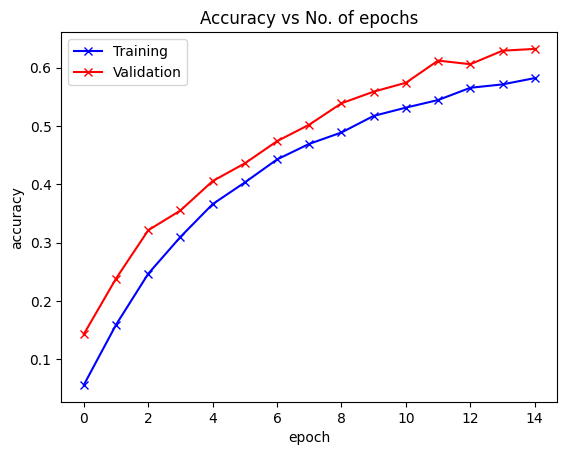

In [10]:
import matplotlib.pyplot as plt
def plot_accuracies(history):
    """ Plot the history of accuracies"""
    val_acc = [x['test_acc'] for x in history]
    train_acc = [x['train_acc'] for x in history]
    plt.plot(train_acc, '-bx')
    plt.plot(val_acc, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(['Training', 'Validation'])
    plt.title('Accuracy vs No. of epochs');
    

plot_accuracies(history)

## Test

In [ ]:
import torch
from torchvision import models, transforms
from PIL import Image

model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 1000)
model.load_state_dict(torch.load('resnet_model.pth'))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# create a new model with the correct final layer
new_model = models.resnet18(pretrained=True)
new_model.fc = nn.Linear(new_model.fc.in_features, 26)

In [ ]:
# copy the weights and biases from the loaded model to the new model
new_model.fc.weight.data = model.fc.weight.data[0:26]
new_model.fc.bias.data = model.fc.bias.data[0:26]

In [ ]:
image_path = '../test_images/00001.jpg'
image = Image.open(image_path)
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
input_tensor = preprocess(image)
input_batch = input_tensor.unsqueeze(0)

In [ ]:
with torch.no_grad():
    output = model(input_batch)

_, predicted_class = output.max(1)

class_names = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
predictedd_class_name = class_names[predicted_class.item()]

print(f'The predicted class is: {predictedd_class_name}')

The predicted class is: b


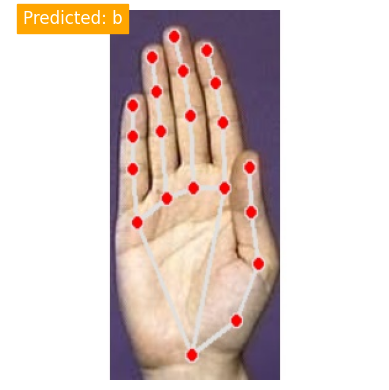

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

image = np.array(image)
plt.imshow(image)
plt.axis('off')
plt.text(10,10, f'Predicted: {predictedd_class_name}', fontsize=12, color='white', backgroundcolor='orange')
plt.show()